# WALKTHROUGH ON ICU CLINICAL DATABASES

eICU Use Case

The primary objective of this work is to develop a predictive model that estimates the number of ventilation days for a patient newly admitted to the ICU. This model will utilize sociodemographic, anthropometric, and clinical data derived from the APACHE Score. The APACHE Score is calculated for ICU patients to assess their risk of mortality.


## Data
Data

For this project, we downloaded the following tables from version 2.0.1 of the eICU project:

1. apacheApsVar
2. apachePatientResult
3. patient

We obtained the eICU demo dataset (a lightweight version of eICU) from [PhysioNet](https://physionet.org/content/eicu-crd-demo/2.0.1/#files-panel)

Detailed descriptions of the table contents can be found on [GitHub](https://github.com/MIT-LCP/eicu-code/tree/master/website/content/eicutables)

In [1]:
# Import necessary libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocesing
from scipy.stats import chi2_contingency 
from sklearn.preprocessing import OneHotEncoder

# Model building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the APACHE variables data
apache_aps_var_df = pd.read_csv("data/apacheApsVar.csv")

# Load the patient results data
apache_patient_result_df = pd.read_csv("data/apachePatientResult.csv")

# Load the patient data
patient_df = pd.read_csv("data/patient.csv")

## Exploring the apacheApsVar Dataset
The `apache_aps_var_df` dataset consists of 2,205 rows and 26 columns, where each row represents a patient and each column an APACHE item. The `patientunitstayid` column is the primary key and identifies each patient record.

Data Cleaning:

- Handling Missing Values: The dataset employs -1 to denote missing values. We will replace these values with actual null values to facilitate data analysis and modeling.
- Missing Value Analysis: We will visualize the proportion of missing values in each column to identify potential data quality and select columns with less than 20% of null proportion.

In [2]:
# Explore dataset using data Wrangler extension
apache_aps_var_df.head()

,apacheapsvarid,patientunitstayid,intubated,vent,dialysis,eyes,motor,verbal,meds,urine,...,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,92788,141765,0,0,0,4,6,5,0,-1.0,...,-1.0,37.8,1.04,-1.0,-1.0,-1.0,28.0,61,-1.0,-1
1,8893,143870,0,0,0,4,6,5,0,-1.0,...,-1.0,34.1,1.14,-1.0,-1.0,-1.0,14.0,140,-1.0,-1
2,79585,144815,0,0,0,4,6,5,0,-1.0,...,-1.0,36.6,0.63,3.6,-1.0,-1.0,6.0,82,0.5,-1
3,203242,145427,0,0,0,4,6,5,0,-1.0,...,-1.0,40.4,1.05,-1.0,-1.0,-1.0,14.0,118,-1.0,-1
4,154681,147307,0,0,0,4,6,5,0,-1.0,...,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1


In [3]:
# We replace -1 data with pd.NA objects
apache_aps_var_df = apache_aps_var_df.replace(-1, pd.NA)

In [ ]:
# We write a function for ploting null proportions

def null_plotter(dataframe):
    """
    Plot a barplot for null proportions of each column in a dataset

    Parameters:
    - A dataframe with null coded as pd.NA object

    Returns:
    - A horizontal barplot 
    """

    # Calculate null proportions
    null_proportions = dataframe.isnull().mean().sort_values()

    # Create a bar plot for NULL proportions
    plt.figure(figsize=(10, 6))
    null_proportions.plot(kind = 'barh', color = 'skyblue')
    plt.title('Proportion of NULL values')
    plt.xlabel('Proportion')
    plt.ylabel('Columns')
    plt.xlim(0,1)
    plt.grid(axis='x')

    plt.tight_layout()
    plt.show()

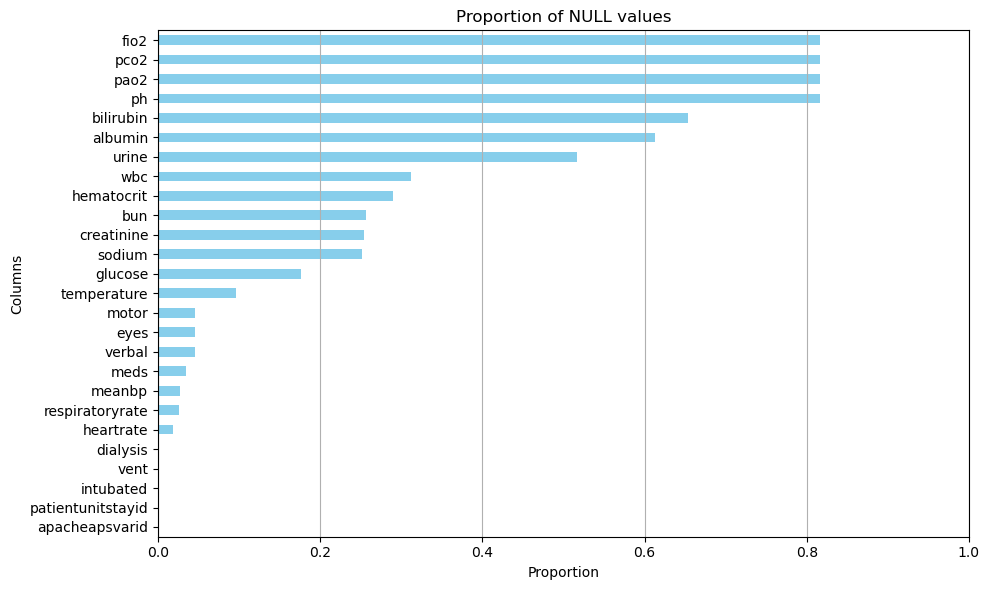

In [7]:
# We plot null proportions
null_plotter(apache_aps_var_df)

As we can see, most columns in the dataset contain over 50% null values, rendering them unusable for analysis. To ensure data quality and reliability, we will focus on columns with less than 20% null values. The selected columns are:

1. `glucose`: Blood glucose level
2. `meanbp`: Mean arterial blood pressure
3. `heartrate`: Heart rate
4. `respiratoryrate`: Respiratory rate
5. `temperature`: Body temperature
6. `meds`: Medication administration that could low awareness y/n
7. `verbal`: Verbal responsiveness for GCS
8. `motor`: Motor responsiveness for GCS
9. `eyes`: Eye opening response for GCS
10. `dialysis`: Dialysis y/n
11. `vent`: Ventilator status y/n
12. `intubated`: Intubation status y/n

In [8]:
# Select predictive variables and patient identifier
apache_var = apache_aps_var_df[[
    'patientunitstayid',
    'glucose',
    'meanbp',
    'heartrate',
    'respiratoryrate',
    'temperature',
    'meds',
    'verbal',
    'motor',
    'eyes',
    'dialysis',
    'vent',
    'intubated'
    ]]

## Exploring the patient Dataset
The `patient_df` dataset contains 2,520 patient records, each identified by a unique `patientunitstayid`. To predict ventilation days, we will focus on variables that remain constant throughout a patient's stay or are collected at the time of ICU admission:

1. `gender`: Patient's gender
2. `age`: Patient's age
3. `ethnicity`: Patient's ethnicity
4. `admissionheight`: Patient's height at admission
5. `admissionweight`: Patient's weight at admission

In this section, we will:

- Analyze missing values: Calculate the percentage of missing values in each column and identify columns with excessive missing data.
- Identify and correct data errors: Check for inconsistencies, outliers, or invalid data entries and take appropriate corrective actions.
- Visualize missing values: Create a plot to visualize the proportion of missing values in each column.


In [9]:
patient_df.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141764,129391,Female,87,Caucasian,59,91,NaN,157.5,23:36:00,...,ICU to SDU,2,stepdown/other,NaN,NaN,18:58:00,344,Home,Alive,002-1039
1,141765,129391,Female,87,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",157.5,23:36:00,...,Emergency Department,1,admit,46.5,45.0,13:14:00,2250,Step-Down Unit (SDU),Alive,002-1039
2,143870,131022,Male,76,Caucasian,68,103,"Endarterectomy, carotid",167.0,20:46:00,...,Operating Room,1,admit,77.5,79.4,10:00:00,793,Floor,Alive,002-12289
3,144815,131736,Female,34,Caucasian,56,82,"Overdose, other toxin, poison or drug",172.7,01:44:00,...,Emergency Department,1,admit,60.3,60.7,20:48:00,1121,Other External,Alive,002-1116
4,145427,132209,Male,61,Caucasian,68,103,"GI perforation/rupture, surgery for",177.8,23:48:00,...,Operating Room,1,admit,91.7,93.1,22:47:00,1369,Floor,Alive,002-12243


In [10]:
# Select relevant patient variables
patient_var = patient_df[[
    'patientunitstayid',
    'gender',
    'age',
    'ethnicity',
    'admissionheight',
    'admissionweight'
    ]]

# Display the first rows of the dataset
patient_var.head()

,patientunitstayid,gender,age,ethnicity,admissionheight,admissionweight
0,141764,Female,87,Caucasian,157.5,NaN
1,141765,Female,87,Caucasian,157.5,46.5
2,143870,Male,76,Caucasian,167.0,77.5
3,144815,Female,34,Caucasian,172.7,60.3
4,145427,Male,61,Caucasian,177.8,91.7


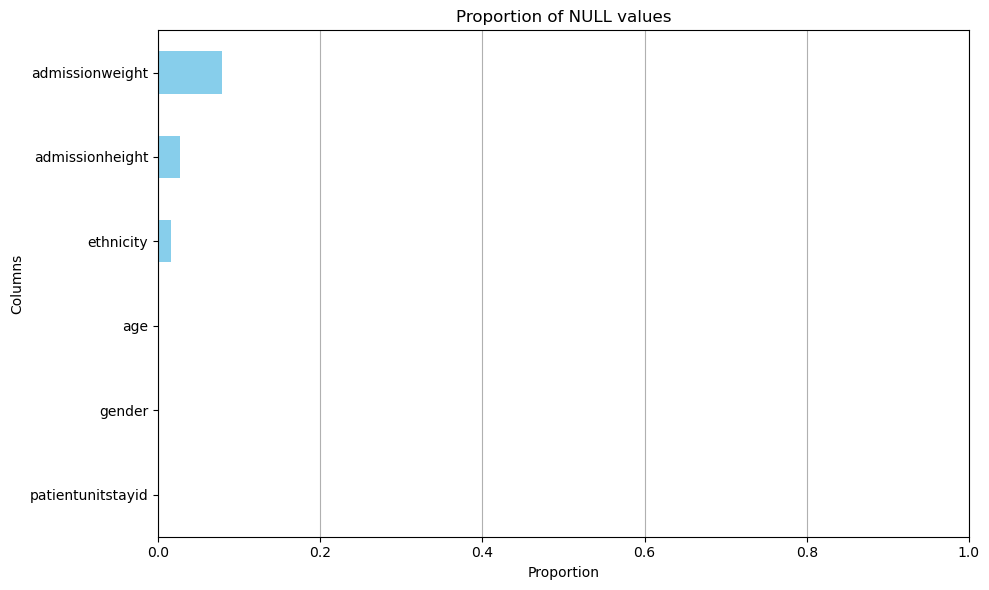

In [11]:
# Plot null proportion
null_plotter(patient_var)

## Exploring the apachePatientResult Dataset
The apachePatientResult dataset contains 3,676 patient records, each representing an instance of the APACHE calculation. From this dataset, we will focus on the `unabridgedactualventdays` variable, which represents the actual number of ventilation days for each patient.

In [12]:
apache_patient_result_df.head()

,apachepatientresultsid,patientunitstayid,physicianspeciality,physicianinterventioncategory,acutephysiologyscore,apachescore,apacheversion,predictedicumortality,actualicumortality,predictediculos,...,predictedhospitallos,actualhospitallos,preopmi,preopcardiaccath,ptcawithin24h,unabridgedunitlos,unabridgedhosplos,actualventdays,predventdays,unabridgedactualventdays
0,31917,141765,hospitalist,Unknown,23,47,IV,0.008247,ALIVE,0.722231,...,2.881710,1.8222,0,0,0,1.5625,1.8222,NaN,NaN,NaN
1,31918,141765,hospitalist,Unknown,23,47,IVa,0.012311,ALIVE,1.374807,...,3.173925,1.8222,0,0,0,1.5625,1.8222,NaN,NaN,NaN
2,21398,143870,family practice,Unknown,43,60,IVa,0.015707,ALIVE,3.021671,...,6.032627,0.8465,0,0,0,0.5506,0.8465,NaN,NaN,NaN
3,21397,143870,family practice,Unknown,43,60,IV,0.017739,ALIVE,3.006522,...,5.955292,0.8465,0,0,0,0.5506,0.8465,NaN,NaN,NaN
4,181,144815,internal medicine,I,25,25,IV,0.001834,ALIVE,0.592446,...,2.196294,0.8063,0,0,0,0.7784,0.8063,NaN,NaN,NaN


In [13]:
# Select variables
vent_days = apache_patient_result_df[[
    'patientunitstayid',
    'unabridgedactualventdays'
    ]]

## Data Integration and Cleaning
To create a comprehensive dataset for model building, we will merge the `apache_var`, `patient_var`, and `vent_days` DataFrames.

Data Integration:

- Merge DataFrames: Combine the DataFrames based on the patientunitstayid column, which serves as a unique identifier for each patient.

Data Cleaning and Preprocessing:

- Check Data Types
- Impute Missing Values
- Correct Data Errors
- Feature Engineering
- Feature Scaling
- Data Exploration 
- Correlation Analysis

In [45]:
# Merge selected apache and patient variables based on patient ID
main_data = pd.merge(
    apache_var,
    patient_var,
    on='patientunitstayid',
    how='inner'
    )

# Merge the combined DataFrame with ventilation days data
main_data = pd.merge(
    main_data,
    vent_days,
    on='patientunitstayid',
    how='inner'
    )

# Display the first few rows of the merged dataset
main_data.head()

,patientunitstayid,glucose,meanbp,heartrate,respiratoryrate,temperature,meds,verbal,motor,eyes,dialysis,vent,intubated,gender,age,ethnicity,admissionheight,admissionweight,unabridgedactualventdays
0,141765,61,108,88,39,36.2,0,5,6,4,0,0,0,Female,87,Caucasian,157.5,46.5,NaN
1,141765,61,108,88,39,36.2,0,5,6,4,0,0,0,Female,87,Caucasian,157.5,46.5,NaN
2,143870,140,47,40,60,36.4,0,5,6,4,0,0,0,Male,76,Caucasian,167.0,77.5,NaN
3,143870,140,47,40,60,36.4,0,5,6,4,0,0,0,Male,76,Caucasian,167.0,77.5,NaN
4,144815,82,61,131,6,36.7,0,5,6,4,0,0,0,Female,34,Caucasian,172.7,60.3,NaN


In [15]:
# Check for datatypes
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3676 entries, 0 to 3675
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patientunitstayid         3676 non-null   int64  
 1   glucose                   3154 non-null   object 
 2   meanbp                    3652 non-null   object 
 3   heartrate                 3664 non-null   object 
 4   respiratoryrate           3646 non-null   object 
 5   temperature               3454 non-null   object 
 6   meds                      3638 non-null   object 
 7   verbal                    3594 non-null   object 
 8   motor                     3594 non-null   object 
 9   eyes                      3594 non-null   object 
 10  dialysis                  3676 non-null   int64  
 11  vent                      3676 non-null   int64  
 12  intubated                 3676 non-null   int64  
 13  gender                    3674 non-null   object 
 14  age     

In [46]:
# Convert gender to numerical representation
main_data['gender'] = main_data['gender'].map({'Female': 0, 'Male': 1})

# Convert age to numeric, handling potential errors
main_data['age'] = pd.to_numeric(main_data['age'], errors='coerce')
# some of the ages are >95, so we cap these values
main_data['age'] = main_data['age'].fillna(main_data['age'].quantile(0.90))

# Rename the target variable for clarity
main_data.rename(columns={'unabridgedactualventdays': 'ventdays'}, inplace=True)

# Replace missing ventilation days with 0
main_data['ventdays'] = main_data['ventdays'].fillna(0)

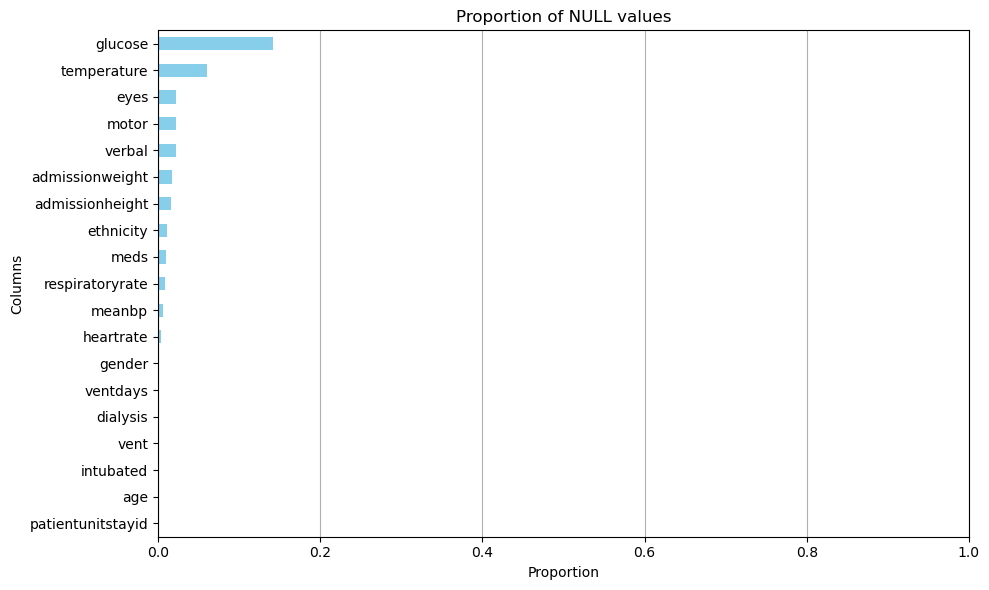

In [17]:
null_plotter(main_data)

The bar chart illustrates the proportion of null values in each column of the dataset.
The columns glucose, temperature, and Glasgow Coma Scale variables (eyes, motor, verbal) exhibit a relatively high proportion of null values.
Most other columns have less than 10% null values. We handle missing values imputing by mean or mode.

First we plot data distribution to check by outliers and data input errors that could impact in mean.

In [ ]:
# Create a function for plotting numerical data distribution
def violin_plotter(data, min_limit=0, max_limit=4000):
    """
    Plot box plot graphics of especified columns of main_data

    Parameters:
    - data: A list of columns
    - min_limit: min limit of y axis
    - max_limit; max limit of y axis

    Returns:
    A box plot comparising data distribution
    """

    # Drop NaN values from the DataFrame
    data = data.dropna()

    plt.figure(figsize=(10, 6))

    # Create a violin plot
    sns.violinplot(data=data, palette='Blues')

    # Picuture title and labeling
    plt.title('Variable distribution')
    plt.xlabel('Variables')
    plt.ylabel('Values')
    plt.ylim(min_limit,max_limit)
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

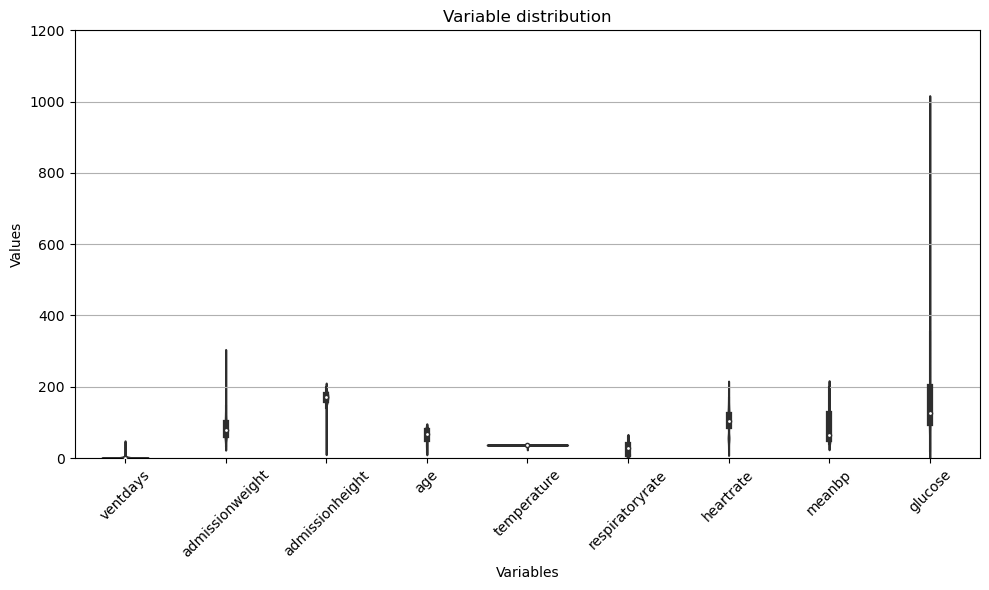

In [28]:
# Select continous numerical data
continuous_vars = [
    'ventdays',
    'admissionweight',
    'admissionheight',
    'age',
    'temperature',
    'respiratoryrate',
    'heartrate',
    'meanbp',
    'glucose'
    ]

violin_plotter(main_data[continuous_vars], max_limit=1200, min_limit=0)

The violin plot provides a comprehensive visualization of the distribution of continuous variables within the main_data dataset.

Key Observations:

- Outliers: Several variables, including admissionweight, admissionheight, and glucose, exhibit outliers, indicated by the extended tails of the violin plots.
- Skewness: admissionweight, glucose, and meanbp are right-skewed, suggesting a longer tail towards higher values. age and admissionheight are left-skewed, indicating a higher concentration of older patients and short patients. respiratoryrate and heartrate appear to be approximately normally distributed. temperature is left-skewed, potentially due to hypothermia cases. ventdays is right-skewed, suggesting a majority of patients had shorter ventilation durations.

Examinig sepecific variables

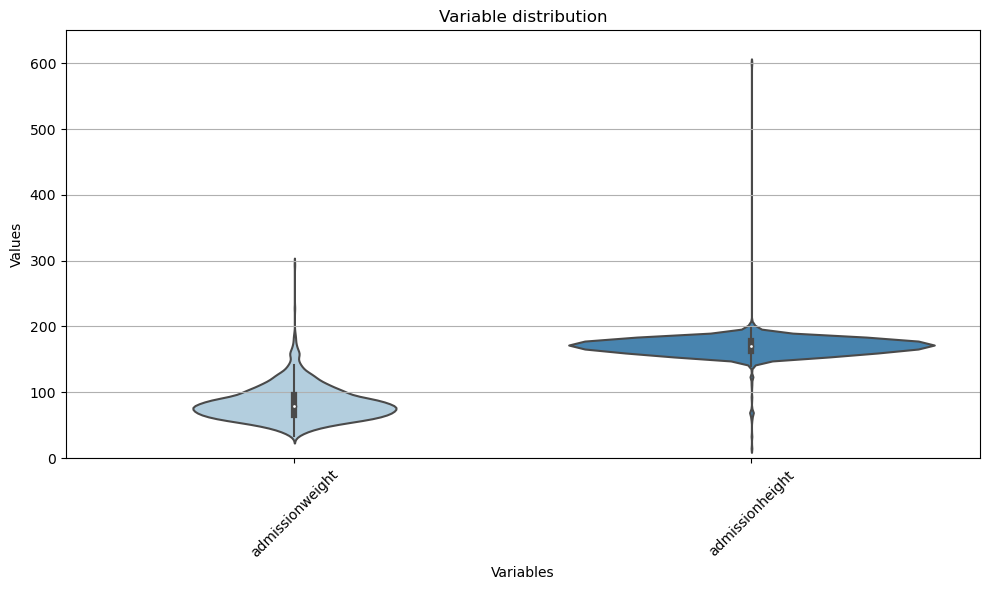

In [47]:
violin_plotter(
    main_data[['admissionweight','admissionheight']],
    max_limit=650)

The box plot visualizes the distribution of admissionweight and admissionheight. Both variables exhibit outliers, particularly in the upper range, indicating potential data entry errors. The distribution of admissionweight appears to be right-skewed, suggesting a longer tail towards higher values. Additionally, the range of values for admissionheight is significantly larger, potentially impacting the overall scale of the data.
To address these issues, we will apply winsorization to the data, capping the outliers at a 90th and 10th percentile to mitigate their influence on the analysis

In [ ]:
def winsorizer(df, columns, cap_value, floor_value):
    """
    A function that winsorize data to deal with outliers

    Parameters: 
    - df: A dataframe
    - cols_to_winsorize: A list of column titles
    - cap_value: Upper limit, an integer between 0 and 1
    - floor_value: Lower limit, an integer between 0 and 1

    Returns:
    - inplace the columns winsorized into df
    """
    for col in columns:
        df[col] = df[col].clip(
            lower=df[col].quantile(floor_value),
            upper=df[col].quantile(cap_value)
            )
    print('data winsorized\n')
        
cols_to_winsorize = ['admissionweight', 'admissionheight']

winsorizer(main_data, cols_to_winsorize, 0.95, 0.05)

data winsorized



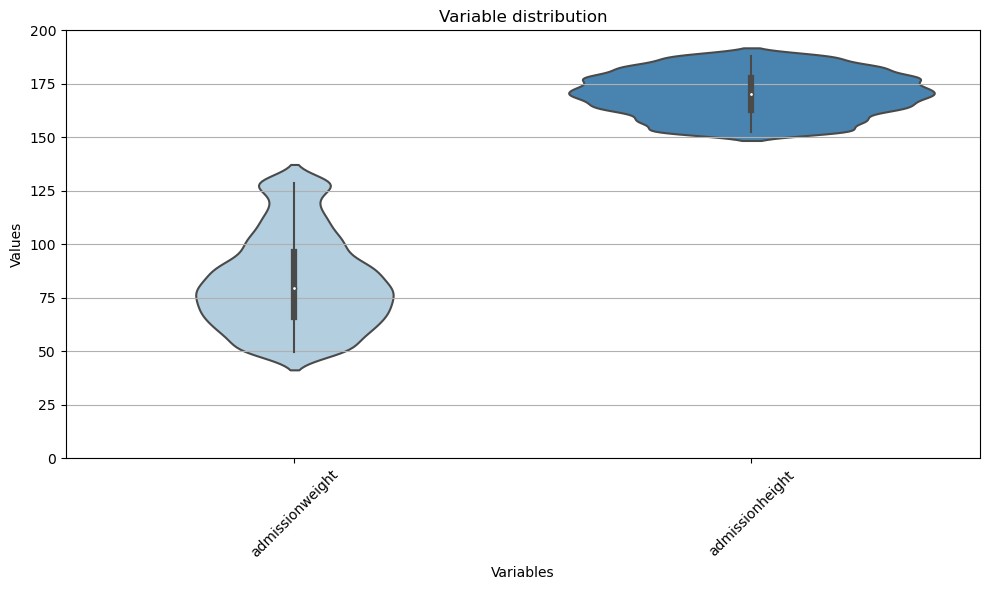

In [49]:
violin_plotter(
    main_data[['admissionweight','admissionheight']],
    max_limit=200)

The box plot illustrates the distribution of admissionweight and admissionheight after applying winsorization. We observe reduced outliers, shorter whiskers and improved symetry of the data.

Now we explore glucose values


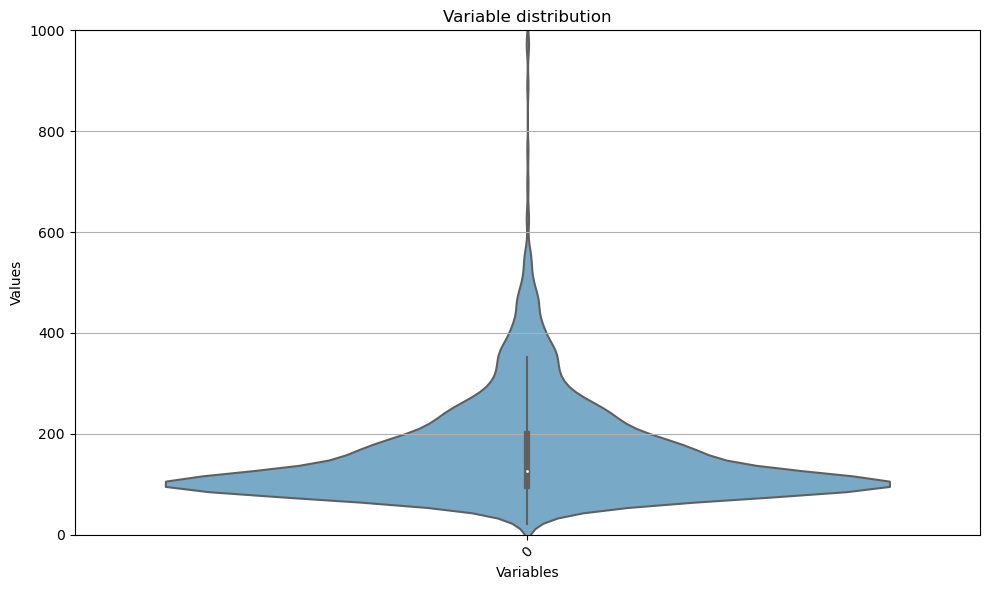

In [42]:
violin_plotter(
    main_data['glucose'],
    max_limit=1000)

We apply winsorization

data winsorized



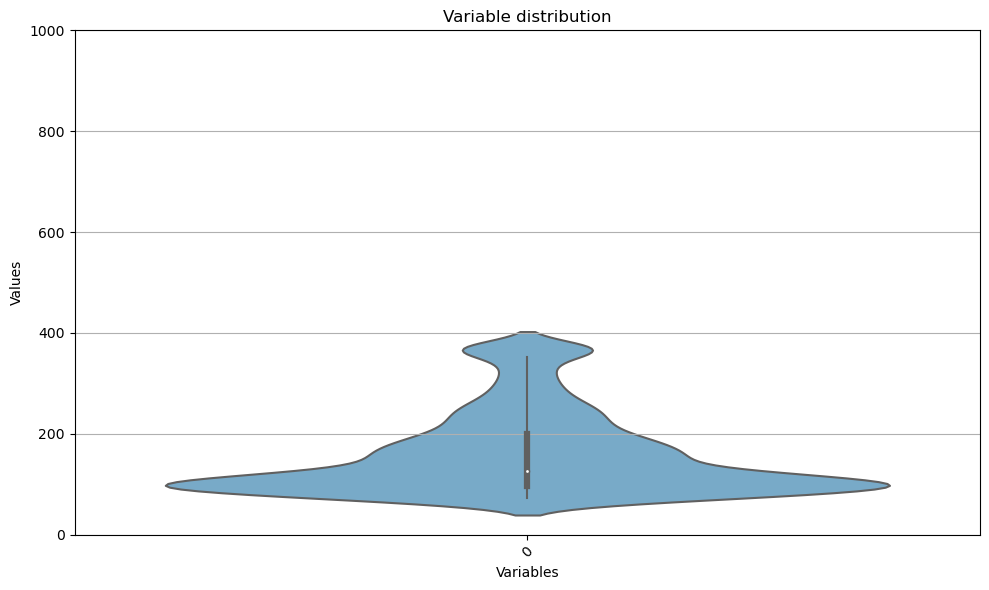

In [ ]:
winsorizer(
    main_data,
    ['glucose'],
    0.99,
    0.01
)

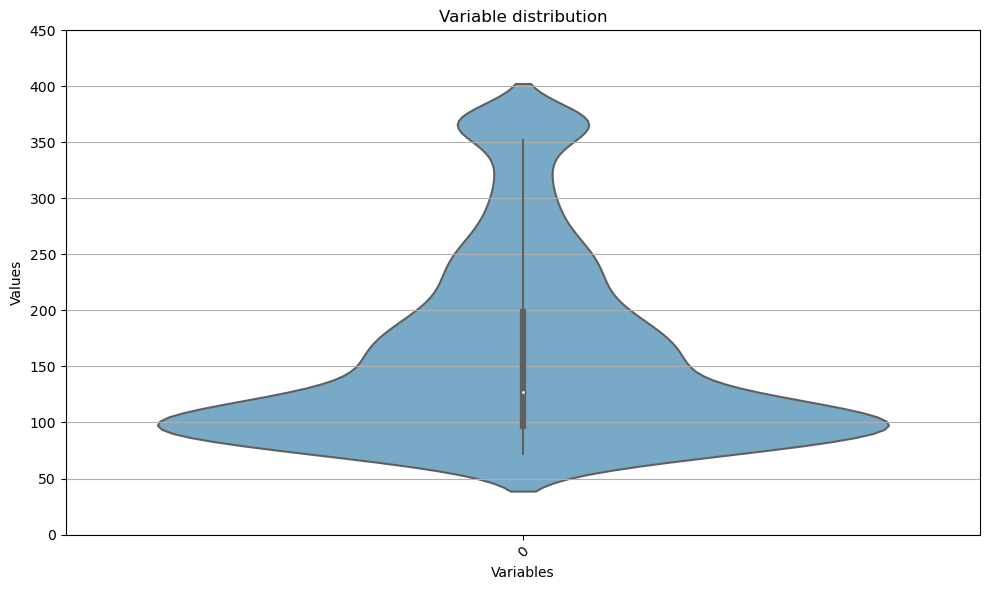

In [52]:
violin_plotter(
    main_data['glucose'],
    max_limit=450
)

Now we observe catetorical data distribution

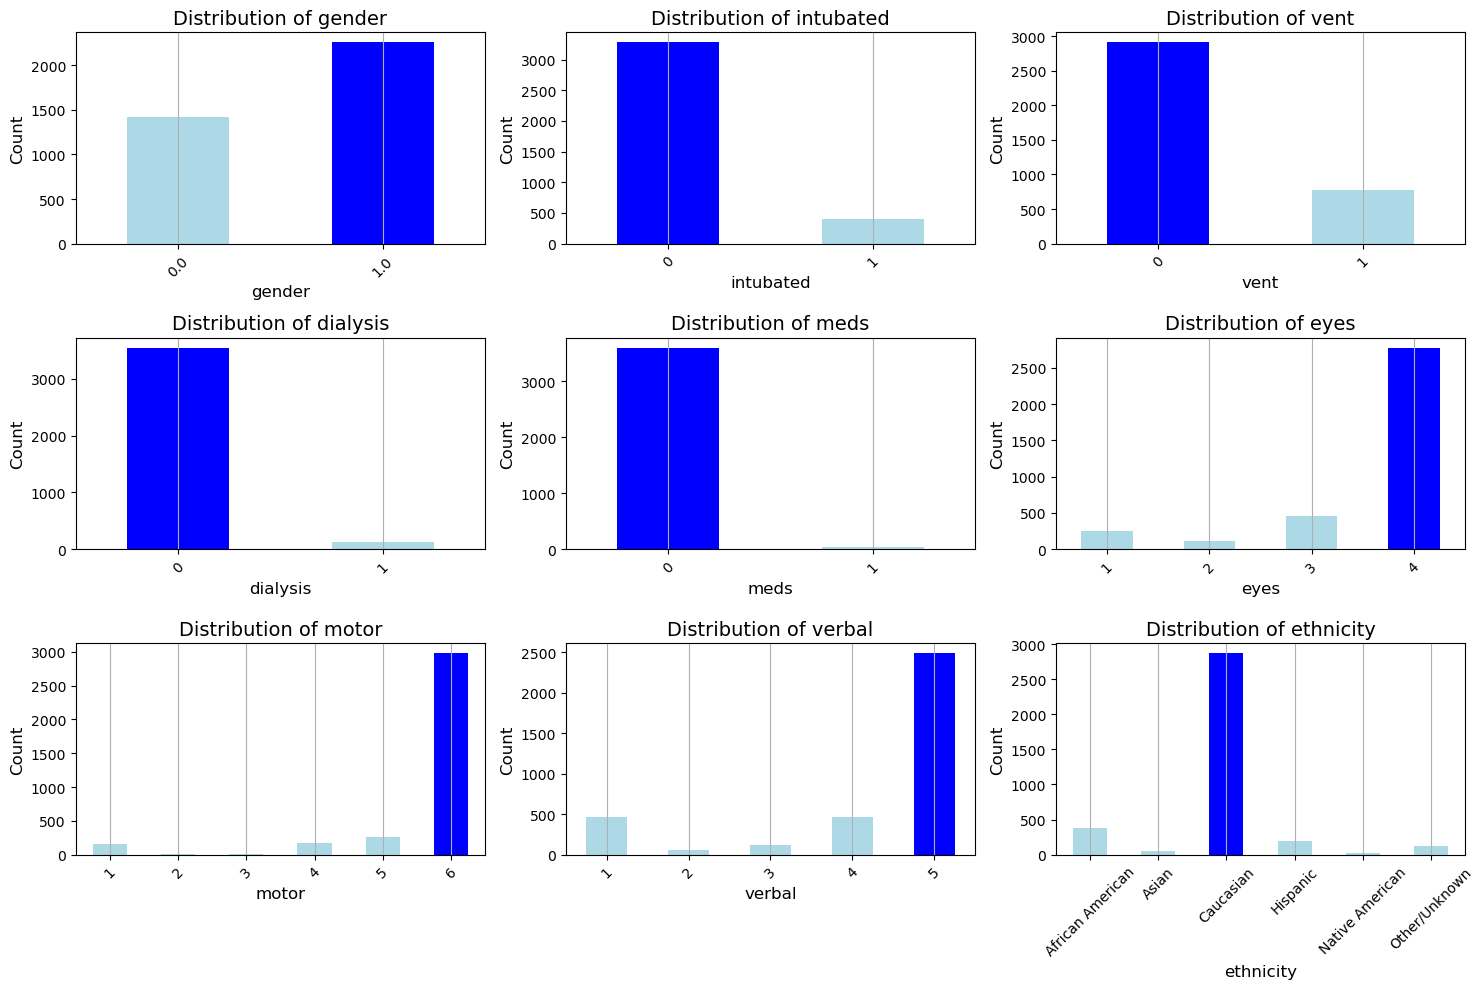

In [ ]:
# Define categorical variables
categorical_vars = [
    'gender',
    'intubated',
    'vent',
    'dialysis',
    'meds',
    'eyes',
    'motor',
    'verbal',
    'ethnicity'
    ]

# Create a figure with a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each categorical variable and plot
for i, var in enumerate(categorical_vars):
    # Group by the categorical variable and count occurrences
    counts = main_data.groupby(var)['patientunitstayid'].count()

    # Determine the maximum count to find the predominant value
    max_count = counts.max()
    
    # Create a color array: darker for the predominant value
    colors = ['lightblue' if count < max_count else 'blue' for count in counts]
    
    # Plot the bar graph on the corresponding axes
    counts.plot(kind='bar', ax=axes[i], color=colors)
    
    # Set title and labels
    axes[i].set_title(f'Distribution of {var}', fontsize=14)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].grid(axis='x')  # Add gridlines for better readability
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-tick labels for better visibility

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


For the categorical variables, we observe a clear dominance of certain categories. Most patients are male and were not intubated, ventilated, on dialysis, or receiving medications that could affect their consciousness. The variables 'eyes,' 'motor,' and 'verbal' are components of the Glasgow Coma Scale. Their distribution suggests that most patients had normal GCS scores.

Having addressed outliers and data distribution issues, we can now proceed to handle missing values. Imputation techniques, such as mean or mode imputation, can be applied to fill in missing data points.

/tmp/ipykernel_7599/2047043293.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_data[col] = main_data[col].fillna(main_data[col].mean())
/tmp/ipykernel_7599/2047043293.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_data[col] = main_data[col].fillna(main_data[col].mode()[0])


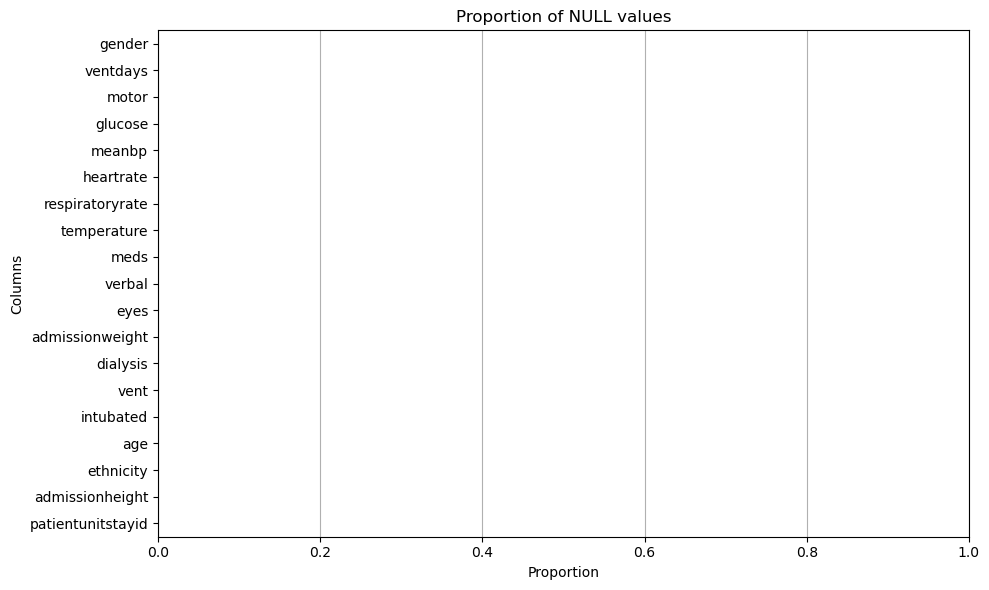

In [56]:
# Identify columns to fill with mean values
cols_to_fill_mean = [
    'admissionweight',
    'admissionheight', 
    'temperature', 
    'respiratoryrate', 
    'heartrate', 
    'meanbp', 
    'glucose'
]

# Identify columns to fill with mode values
cols_to_fill_mode = [
    'eyes',
    'motor',
    'verbal',
    'ethnicity',
    'meds'
]

# Fill missing values in specified columns with their respective means
for col in cols_to_fill_mean:
    main_data[col] = main_data[col].fillna(main_data[col].mean())

# Fill missing values in specified columns with their respective modes
for col in cols_to_fill_mode:
    main_data[col] = main_data[col].fillna(main_data[col].mode()[0])

# replot
null_plotter(main_data)

We engineer the features BMI and GCS from the raw data. BMI is calculated as the ratio of weight to the square of height. GCS is derived by summing the scores for eye, motor, and verbal responses.

In [57]:
# Calculate Body Mass Index (BMI) from weight and height
main_data['bmi'] = main_data['admissionweight'] / ((main_data['admissionheight']/100)**2)

# Drop unnecesary columns
main_data.drop(
    columns=['admissionweight', 'admissionheight'],
    axis=1,
    inplace=True
)

# Calculate Glasgow Coma Scale from its raw data
main_data['gcs'] = main_data['eyes'] + main_data['motor'] + main_data['verbal']

# Drop unnecesary columns
main_data.drop(
    columns=['eyes', 'motor', 'verbal'],
    axis=1,
    inplace=True
)

# Visualize
main_data.head()


,patientunitstayid,glucose,meanbp,heartrate,respiratoryrate,temperature,meds,dialysis,vent,intubated,gender,age,ethnicity,ventdays,bmi,gcs
0,141765,72.0,108.0,88.0,39.0,36.2,0,0,0,0,0.0,87.0,Caucasian,0.0,20.035273,15
1,141765,72.0,108.0,88.0,39.0,36.2,0,0,0,0,0.0,87.0,Caucasian,0.0,20.035273,15
2,143870,140.0,47.0,40.0,60.0,36.4,0,0,0,0,1.0,76.0,Caucasian,0.0,27.788734,15
3,143870,140.0,47.0,40.0,60.0,36.4,0,0,0,0,1.0,76.0,Caucasian,0.0,27.788734,15
4,144815,82.0,61.0,131.0,6.0,36.7,0,0,0,0,0.0,34.0,Caucasian,0.0,20.217741,15


We proceed to examine the correlation matrix to assess the linear relationships between variables

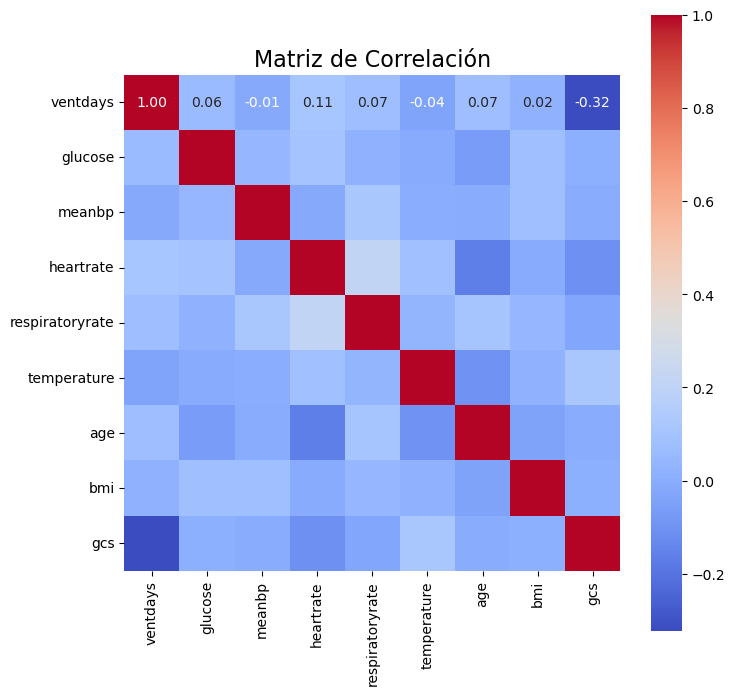

In [ ]:
corr_vars = [
    'ventdays',
    'glucose',
    'meanbp',
    'heartrate',
    'respiratoryrate',
    'temperature',
    'age',
    'bmi',
    'gcs'
]

# Calculate corr matirx
correlation_matrix = main_data[corr_vars].corr()

# Figure size
plt.figure(figsize=(8, 10))

# create heatmap for corr matrix
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": .8}
    )

# Configure title
plt.title('Matriz de Correlación', fontsize=16)

# plot
plt.show()

The correlation matrix reveals a weak relationship between ventdays and most of the predictive variables. However, we observe a moderate negative correlation with gcs and a weak positive correlation with heartrate.

To examine categorical variables, we check chi square test

In [ ]:
categorical_vars = [
    'ethnicity',
    'gender',
    'intubated',
    'vent',
    'dialysis',
    'meds'
    ]

# Initialize an empty list to store the results
results = []

# Loop through each categorical variable to test against 'ventdays'
for var in categorical_vars:
    # Create a contingency table
    contingency_table = pd.crosstab(main_data[var], main_data['ventdays'])
    
    # Perform chi-square test
    stat, p, dof, expected = chi2_contingency(contingency_table)
    
    # Interpret the p-value
    alpha = 0.05
    print(f"Testing independence between {var} and ventdays:")
    print("p-value:", p)
    if p <= alpha:
        print("Dependent (reject H0)\n")
    else:
        print("Independent (H0 holds true)\n")

Testing independence between ethnicity and ventdays:
p-value: 1.4571615204477258e-13
Dependent (reject H0)

Testing independence between gender and ventdays:
p-value: 0.00021081968636592837
Dependent (reject H0)

Testing independence between intubated and ventdays:
p-value: 1.999373358653633e-245
Dependent (reject H0)

Testing independence between vent and ventdays:
p-value: 0.0
Dependent (reject H0)

Testing independence between dialysis and ventdays:
p-value: 0.00026914769366085967
Dependent (reject H0)

Testing independence between meds and ventdays:
p-value: 4.3785284671013715e-21
Dependent (reject H0)



The statistical tests revealed that all categorical variables are significantly associated with the number of ventilation days. This association may be influenced by the imbalanced distribution of these categorical variables.

In order to use this data for training the model we get dummies variables for trainig the model.

In [ ]:
# One-Hot encoding categorical variables
one_hot_encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = one_hot_encoder.fit_transform(main_data[categorical_vars])
categorical_encoded_df = pd.DataFrame(
    categorical_encoded,
    columns = one_hot_encoder.get_feature_names_out(categorical_vars),
    index = main_data.index
    )

# Combine this variables with original dataframe
df_encoded = pd.concat(
    [main_data.drop(categorical_vars, axis=1), categorical_encoded_df],
     axis=1)

df_encoded.head()

,patientunitstayid,glucose,meanbp,heartrate,respiratoryrate,temperature,age,ventdays,bmi,gcs,...,gender_1.0,gender_nan,intubated_0,intubated_1,vent_0,vent_1,dialysis_0,dialysis_1,meds_0,meds_1
0,141765,72.0,108.0,88.0,39.0,36.2,87.0,0.0,20.035273,15,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,141765,72.0,108.0,88.0,39.0,36.2,87.0,0.0,20.035273,15,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,143870,140.0,47.0,40.0,60.0,36.4,76.0,0.0,27.788734,15,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,143870,140.0,47.0,40.0,60.0,36.4,76.0,0.0,27.788734,15,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,144815,82.0,61.0,131.0,6.0,36.7,34.0,0.0,20.217741,15,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


Given the observed skew and presence of outliers in the continuous data distributions, a normalization technique robust to outliers is necessary for scaling. Based on this exploration ([link to scikit-learn post](https://scikit-learn.org/dev/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section)), we have chosen the RobustScaler. This scaler utilizes percentiles for normalization, effectively mitigating the influence of outliers while preserving their presence in the transformed data.

In [ ]:
# Define vars to normalize
nomalize_vars = [var for var in corr_vars if var != 'ventdays']

# Import scaler
from sklearn.preprocessing import RobustScaler

# Initialize scaler
scaler = RobustScaler()

# Transform data
scaled_data = scaler.fit_transform(df_encoded[nomalize_vars])

# Create a DataFrame for the scaled data
scaled_df = pd.DataFrame(
    scaled_data,
    columns=nomalize_vars,
    index=df_encoded.index
)

# Update the original DataFrame with the scaled values
df_encoded[nomalize_vars] = scaled_df

# Delete primary key column
df_encoded.drop(columns=['patientunitstayid'], axis=1, inplace=True)

# Display the first rows
df_encoded.head()

,patientunitstayid,glucose,meanbp,heartrate,respiratoryrate,temperature,age,ventdays,bmi,gcs,...,gender_1.0,gender_nan,intubated_0,intubated_1,vent_0,vent_1,dialysis_0,dialysis_1,meds_0,meds_1
0,141765,-0.929412,0.632353,-0.515152,0.500,-0.462328,0.84,0.0,-0.809412,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,141765,-0.929412,0.632353,-0.515152,0.500,-0.462328,0.84,0.0,-0.809412,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,143870,-0.129412,-0.264706,-1.969697,1.375,-0.062328,0.40,0.0,0.054042,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,143870,-0.129412,-0.264706,-1.969697,1.375,-0.062328,0.40,0.0,0.054042,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,144815,-0.811765,-0.058824,0.787879,-0.875,0.537672,-1.28,0.0,-0.789091,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
# divide independent from dependent variables
x = df_encoded.loc[:, df_encoded.columns != 'ventdays'] # independent variable
y = df_encoded['ventdays'] # dependent variable

# split data 80/20 for training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [ ]:
regr = RandomForestRegressor()

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=regr,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42)
random_search.fit(x_train, y_train)

# Best parameters and score
print("Best parameters:", random_search.best_params_)
#print("Best score:", random_search.best_score_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Create the model with the best parameters
rf_model = RandomForestRegressor(
    n_estimators=266,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    criterion='squared_error')

# Train the model
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

/home/acao/anaconda3/envs/actividad1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/acao/anaconda3/envs/actividad1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


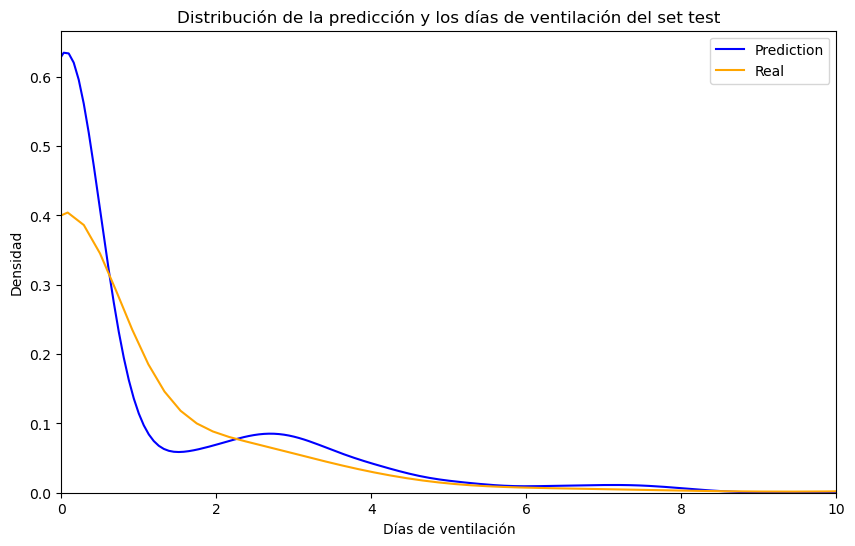

In [ ]:
# Create a dataframe for plotting
plotting_df = pd.DataFrame(
    {
        'Predictions':y_pred,
        'Actual':y_test
    }
)

# Set figuresize
plt.figure(figsize = (10,6))

# Plot both variables
sns.kdeplot(
    data=plotting_df,
    x='Predictions',
    label='Prediction',
    color='blue')

sns.kdeplot(
    data=plotting_df,
    x='Actual',
    label='Real',
    color='orange')

# Set limits and title
plt.xlim([0, 10])
plt.title('Distribución de la predicción y los días de ventilación del set test')
plt.xlabel('Días de ventilación')
plt.ylabel('Densidad')
plt.legend()  # Show legend to differentiate the lines
plt.show()

Both the predicted and actual ventilation days exhibit a right-skewed distribution, this indicates that majority of patients had few ventilation days. The model generally follows the trend of the actual distribution but seems to slightly underestimate the days of ventilation, sugesting the model's tendency to favor the majority class.

In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(rf_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the mean and standard deviation of the scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV score:", cv_scores.std())

Cross-validation scores: [-1.12929684 -2.32298883 -1.98918449 -1.73531407 -3.51299601]
Mean CV score: -2.137956051322106
Standard deviation of CV score: 0.7907741738428712


The cross-validation results indicate that the Random Forest model exhibits reasonable performance on average, as evidenced by the relatively low negative MSE. However, the high variability in the cross-validation scores suggests that the model might be sensitive to different subsets of the data, potentially due to the imbalanced data distribution.

To address this issue, we can apply L2 regularization (Ridge regression) to the model. This technique penalizes large coefficient values, leading to a more robust model and reducing the risk of overfitting

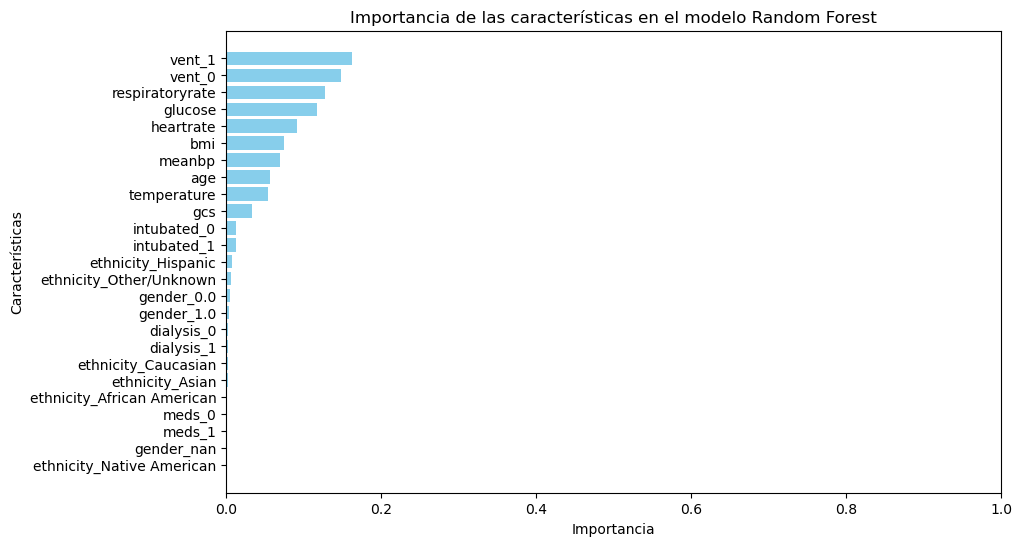

In [98]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a dataframe
importance_df = pd.DataFrame(
    {'Feature':x_train.columns,
     'Importance':importances}
)

# Sort df by importance
importance_df = importance_df.sort_values(
    by='Importance',
    ascending=True
)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Importancia de las características en el modelo Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.xlim(0, 1)  # Set x-axis limits for better visualization
plt.show()

In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R² Score: {r2:.2f}')

Mean Absolute Error: 0.44
Mean Squared Error: 3.85
Root Mean Squared Error: 1.96
R² Score: 0.49


The model's predictions are off by approximately 0.44 days (or 10.6 hours) on average, as indicated by the Mean Absolute Error. The Root Mean Squared Error of 1.96 days suggests that, on average, the model's predictions deviate by nearly 2 days from the actual values.

The R-squared value of 0.49 indicates that the model explains approximately 49% of the variance in ventilation days. While this is a moderate level of explanation, a significant portion of the variance remains unaccounted for.

To improve the model's performance, collecting additional data, particularly variables like FiO2, PCO2, and PO2, could be beneficial. These variables, which are routinely monitored in clinical practice, can provide valuable information about the patient's respiratory status and may enhance the model's predictive accuracy.